In [1]:
from analysis.utils import select_experiment, select_run, GlobalPlotter
import mlflow.tracking
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from data.xrtransforms import SeasonalStdizer
import cartopy

cmap_balance = cmocean.cm.balance
proj_robinson = cartopy.crs.Robinson
plotter = GlobalPlotter()
%matplotlib notebook


/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/intake/source/discovery.py:285: UserWarning: Plugin name collision for "netcdf" from
    /home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/intake_iris/netcdf.py
and
    /home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/intake_xarray/netcdf.py
Keeping plugin from first location.
  % (plugin_name, orig_path, new_path))


Using cached version!
Using cached version!


In [2]:
run = select_run(cols = ['params.CO2', 'params.factor'], experiment_ids=('19',))

                              run_id experiment_id params.CO2 params.factor
0   359a13e63c9744d18336a7b04380569f            19          1             8
1   7a60369c9d5b48058366adef1df59728            19          1             7
2   b85d663b7a1f4e59b09b0d3813cbcab8            19          1             6
3   0c1de3ebefec40748311812a482a8024            19          1             5
4   a5049bd09c7e409791944731e5631a10            19          0             8
5   8f038ef65bdb4667a815029ccf8be3c4            19          0             7
6   2ebecb60c35642fbb1b60d1f6d33df2d            19          0             6
7   1dad89889fae43e798d8fbb171627ad0            19          0             5
8   743777154cb745cf8a4272dcbd3fa189            19          0             4
9   e5e4964d11aa4be1b70143f2289ccfb0            19          1            10
10  f4df0dbb52924d649224c4507cd160aa            19          0            10
11  29399585cd654ffbbac18531738ce984            19          1            10
12  4feb4b3a

In [3]:
client = mlflow.tracking.MlflowClient()
data_file = client.download_artifacts(run.run_id, 'forcing')

In [4]:
data = xr.open_zarr(data_file)
data = data.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))

In [5]:
data

,Array,Chunk
Bytes,33.90 GB,148.61 MB
Shape,"(7300, 645, 900)","(32, 645, 900)"
Count,230 Tasks,229 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,33.90 GB,148.61 MB
Shape,"(7300, 645, 900)","(32, 645, 900)"
Count,230 Tasks,229 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [7]:
data.isel(time=slice(1, 10)).max().compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    S_x      float64 6.252e-06
    S_y      float64 9.148e-06
    usurf    float64 1.617
    vsurf    float64 1.663

In [13]:
import numpy as np
from scipy.stats import norm
quantiles = data['usurf'].isel(time=slice(0, 10)).quantile(np.arange(1e-5, 1+1e-5, 1e-5)).compute()
quantiles = np.concatenate((np.array([-5,]), quantiles, np.array([5, ])))
normal_quantiles = norm.ppf(np.arange(1e-5, 1+1e-5, 1e-5))
normal_quantiles = np.concatenate((np.array([-20,]), normal_quantiles, np.array([20, ])))


def _transform(value):
    value[np.isnan(value)] = 0
    quantile_index = np.searchsorted(quantiles, value) - 1
    v1 = quantiles[quantile_index]
    v2 = quantiles[quantile_index + 1]
    r = (value - v1) / (v2 - v1)
    v1 = normal_quantiles[quantile_index]
    v2 = normal_quantiles[quantile_index + 1]
    result =  v1 + r * (v2 - v1)
    result[np.isnan(value)] = np.nan
    return result

from sklearn.preprocessing import QuantileTransformer
t = QuantileTransformer(output_distribution='normal')
    

In [20]:
len(quantiles)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100002

In [16]:
new = t.fit_transform(data['usurf'].isel(time=slice(0, 100)).compute().data.reshape((-1, 1)))

<IPython.core.display.Javascript object>


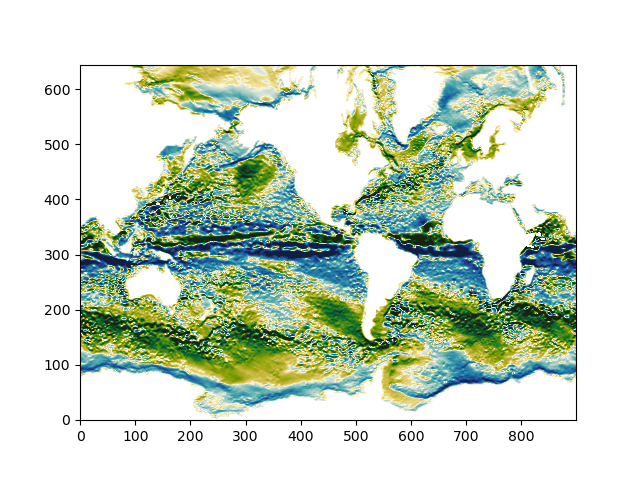

In [59]:
%matplotlib notebook
plt.figure()
plt.imshow(new[600, ...], origin='lower', vmin=-1.96, vmax=1.96, cmap=cmocean.cm.delta)

<IPython.core.display.Javascript object>


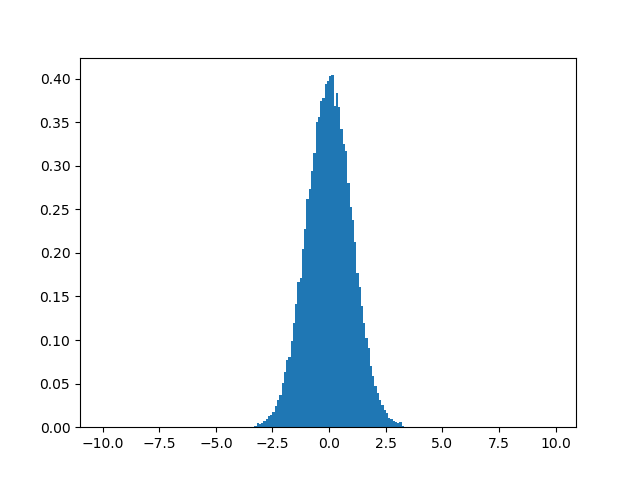

In [17]:
plt.figure()
_ = plt.hist(new.ravel(), bins=np.arange(-10, 10, 0.1), density=True)

<IPython.core.display.Javascript object>


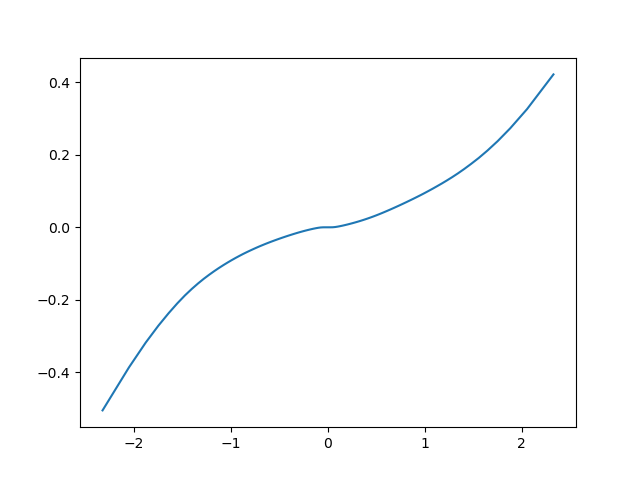

In [15]:
%matplotlib notebook
plt.figure()
plt.plot(norm.ppf(np.arange(0.01, 1, 0.01)), quantiles['usurf'])

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


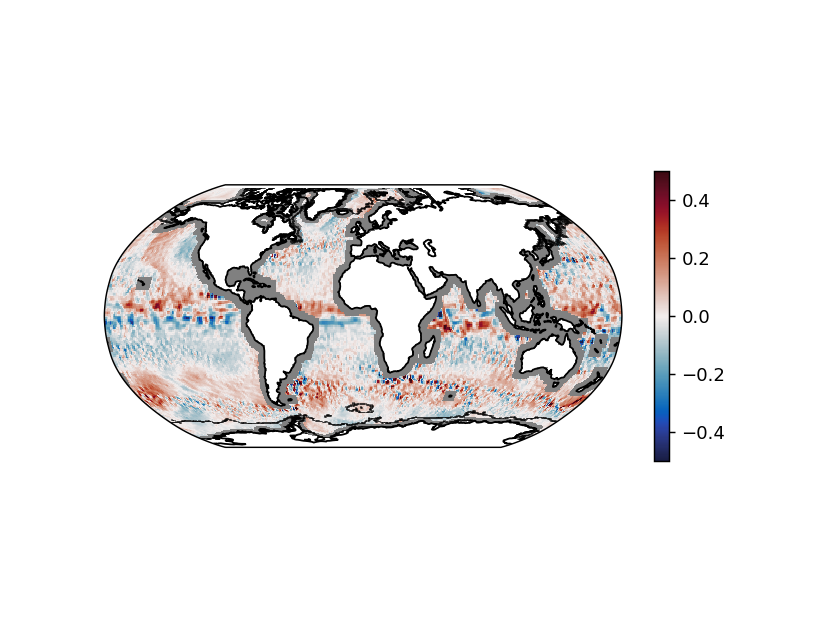

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [8]:
plotter.plot(data['vsurf'].isel(time=0), lon=0, projection_cls=proj_robinson, cmap=cmap_balance, vmin=-0.5, vmax=0.5)

In [12]:
data['usurf'].encoding

{'chunks': (32, 609, 900),
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64')}

In [13]:
data['S_x'].encoding

{'chunks': (32, 609, 900),
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64')}

In [14]:
from dask.diagnostics import ProgressBar, ResourceProfiler
import dask

d1 = data.sel(longitude=slice(-40, -20), latitude=slice(30, 50))
d2 = data.sel(longitude=slice(-70, -40), latitude=slice(30, 50))

print(d1.nbytes / 1e9)

0.739256928


In [7]:
d1

,Array,Chunk
Bytes,184.80 MB,844.80 kB
Shape,"(7000, 66, 50)","(32, 66, 50)"
Count,658 Tasks,219 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,184.80 MB,844.80 kB
Shape,"(7000, 66, 50)","(32, 66, 50)"
Count,658 Tasks,219 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [8]:
type(d1['usurf'].data)

dask.array.core.Array

In [9]:
dask.__version__

'2.23.0'

In [15]:
with ProgressBar(), ResourceProfiler() as prof:
    d1_val = d1.compute()

[########################################] | 100% Completed |  5min  4.5s


In [16]:
dask.__version__

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'2.23.0'

In [17]:
prof.results

[ResourceData(time=1235464.319442389, mem=502.6816, cpu=0.0),
 ResourceData(time=1235465.329093405, mem=506.044416, cpu=67.4),
 ResourceData(time=1235466.330103216, mem=508.616704, cpu=65.9),
 ResourceData(time=1235467.331098757, mem=699.260928, cpu=67.9),
 ResourceData(time=1235468.332098474, mem=641.937408, cpu=69.9),
 ResourceData(time=1235469.333101442, mem=609.189888, cpu=72.9),
 ResourceData(time=1235470.334096437, mem=545.222656, cpu=68.9),
 ResourceData(time=1235471.335487097, mem=536.997888, cpu=72.9),
 ResourceData(time=1235472.336968757, mem=523.005952, cpu=68.9),
 ResourceData(time=1235473.338095433, mem=527.42144, cpu=73.9),
 ResourceData(time=1235474.339446463, mem=561.381376, cpu=73.9),
 ResourceData(time=1235475.340813033, mem=563.920896, cpu=74.9),
 ResourceData(time=1235476.342249053, mem=532.942848, cpu=69.9),
 ResourceData(time=1235477.343099999, mem=597.377024, cpu=76.9),
 ResourceData(time=1235478.344105843, mem=656.146432, cpu=76.9),
 ResourceData(time=1235479.34

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


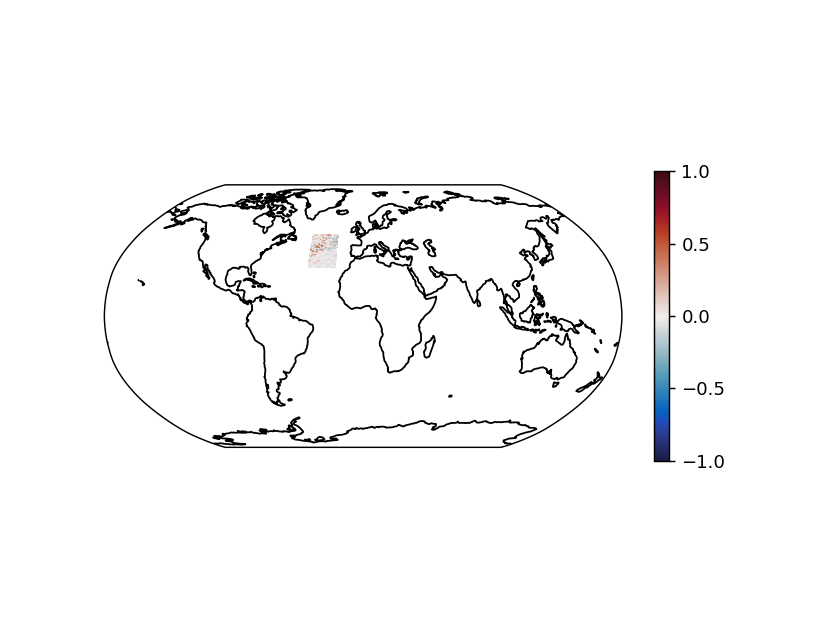

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [20]:
plotter.plot(d1_val.isel(time=5000)['usurf'], cmap=cmap_balance, vmin=-1, vmax=1, projection_cls=proj_robinson, lon=0.)

<IPython.core.display.Javascript object>


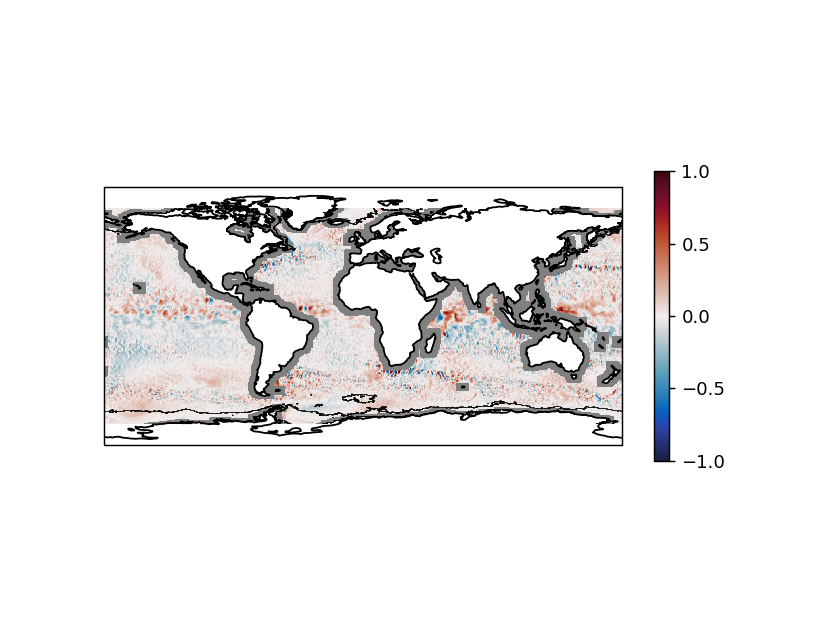

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [15]:
plotter.plot(data.vsurf.isel(time=0), lon=0., cmap=cmap_balance, vmin=-1, vmax=1)

In [1]:
t = SeasonalStdizer(std=True)
with ProgressBar():
    t.fit(data)

NameError: name 'SeasonalStdizer' is not defined

In [9]:
data_n = t(data)

In [29]:
data_v = data.chunk(dict(time=-1, longitude=28, latitude=17))

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
data_v = data.chunk(dict(time=100, longitude=450, latitude=275))
data_v = data_v.chunk(dict(time=400, longitude=225, latitude=137))
data_v = data_v.chunk(dict(time=1600, longitude=112, latitude=68))
data_v = data_v.chunk(dict(time=3200, longitude=56, latitude=34))
data_v = data_v.chunk(dict(time=-1, longitude=28, latitude=17))

In [7]:
import dask.array as da

In [22]:
v = da.random.randint(0, 10, (100, 1000), chunks=(10, -1))

In [23]:
v

dask.array<randint, shape=(100, 1000), dtype=int64, chunksize=(10, 1000), chunktype=numpy.ndarray>

In [10]:
d = v.rechunk((5, -1))

In [11]:
d

dask.array<rechunk-merge, shape=(10, 100), dtype=int64, chunksize=(5, 100), chunktype=numpy.ndarray>

In [26]:
from dask import delayed
import numpy as np
def func(x):
    return 2*x
delayed_func = delayed(func)
new_v = da.concatenate([da.from_delayed(delayed_func(v[start:min(start+5, 100), :]), shape=(5, 1000), dtype=np.int64)
                       for start in range(0, 100, 5)])

In [29]:
import dask
z = dask.delayed(2)

In [31]:
z.compute()

2

In [30]:
with ProgressBar():
    test = data_v.isel(longitude=slice(0, 50), latitude=slice(0, 50)).compute()

[####                                    ] | 11% Completed | 26.5s


KeyboardInterrupt: 

In [12]:
plt.savefig('histtemp.jpg', dpi=300)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
t = SeasonalStdizer()
test = t.fit_transform(data)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [8]:
u = t.transform(data)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
u.isel(time=slice(25, 50)).compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:    (latitude: 550, longitude: 900, time: 25)
Coordinates:
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
  * time       (time) object 0181-01-26 12:00:00 ... 0181-02-19 12:00:00
Data variables:
    S_x        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    S_y        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    usurf      (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    vsurf      (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [38]:
data['time'].dt.month.dtype

dtype('int64')

In [8]:
from dask import delayed
import dask.array as da
import numpy as np
@delayed
def get_months(times):
    return times.dt.month

def all_months(times):
    return xr.concat((xr.DataArray(data=da.from_delayed(get_months(times[start:start+100]), 
                                                        shape=(100,), dtype=np.int64),
                                   coords=dict(time=times[start:start+100]), dims=('time',))
                                   for start in range(0, 4300, 100)), 'time')

months = all_months(data['time'])

In [15]:
for k,v in data.items():
    print(k)
    print(v)

S_x
<xarray.DataArray 'S_x' (time: 4400, latitude: 550, longitude: 900)>
dask.array<mul, shape=(4400, 550, 900), dtype=float64, chunksize=(25, 550, 900), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0193-01-17 12:00:00
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
Attributes:
    type:     output
S_y
<xarray.DataArray 'S_y' (time: 4400, latitude: 550, longitude: 900)>
dask.array<mul, shape=(4400, 550, 900), dtype=float64, chunksize=(25, 550, 900), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0193-01-17 12:00:00
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
Attributes:
    type:     output
usurf
<xarray.DataArray 'usurf' (time: 4400, latitude: 550, longitude: 900)>
dask.array<zarr, shap

In [147]:
@delayed
def get_transformed(data, var_name):
    times = data.time
    months = times.dt.month
    r = data - monthly_means[var_name].sel(month=months)
    del r['month']
    return r.values

def all_data(data):
    sub_datasets = []
    for start in range(0, 4300, 100):
        sub_data = data.isel(time=slice(start, start+100))
        sub_coords = sub_data.coords
        new_xr_arrays = {}
        for k, val in sub_data.items():
            new_shape = val.shape
            dims = val.dims
            transformed = get_transformed(val, k)
            dask_array = da.from_delayed(transformed, shape=new_shape, dtype=np.float64)
            new_xr_array = xr.DataArray(data=dask_array, coords=sub_coords, dims=dims)
            new_xr_arrays[k] = new_xr_array
        new_ds = xr.Dataset(new_xr_arrays)
        sub_datasets.append(new_ds)
    return xr.concat(sub_datasets, dim='time')

data_n = all_data(data)
data_n

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Array,Chunk
Bytes,17.03 GB,396.00 MB
Shape,"(4300, 550, 900)","(100, 550, 900)"
Count,697 Tasks,43 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,17.03 GB,396.00 MB
Shape,"(4300, 550, 900)","(100, 550, 900)"
Count,697 Tasks,43 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [152]:
data_n['usurf'].isel(time=2000).std().compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray 'usurf' ()>
array(0.10822284)
Coordinates:
    time     object 0186-06-24 12:00:00

In [49]:
data_n['usurf'].isel(time=0)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray 'usurf' (latitude: 550, longitude: 900)>
dask.array<getitem, shape=(550, 900), dtype=float64, chunksize=(550, 900), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
    time       object 0181-01-01 12:00:00

In [ ]:
def remove_seasonal_means(data):
    months = all_months(data.time)
    

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
data = data.assign_coords(dict(month=months))

In [41]:
e = data.groupby('time.month') - monthly_grouped.mean()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
del e['month']

In [46]:
data

<xarray.Dataset>
Dimensions:    (latitude: 550, longitude: 900, time: 500)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0182-05-15 12:00:00
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 5 5 5 5 5 5 5 5 5 5 5 5
Data variables:
    S_x        (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>
    S_y        (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>
    usurf      (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>
    vsurf      (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>

In [29]:
data

<xarray.Dataset>
Dimensions:    (latitude: 550, longitude: 900, time: 500)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0182-05-15 12:00:00
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
Data variables:
    S_x        (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>
    S_y        (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>
    usurf      (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>
    vsurf      (time, latitude, longitude) float64 dask.array<chunksize=(25, 550, 900), meta=np.ndarray>

In [22]:
test = test.drop_vars('month')

In [109]:
def standardize(x):
    return (x - x.mean(dim='time')) / x.std(dim='time')
monthly_grouped = data.groupby('time.month')
monthly_means = monthly_grouped.mean()

In [110]:
with ProgressBar():
    monthly_means = monthly_means.compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[#                                       ] | 3% Completed | 11.8s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  5min  1.3s


In [16]:
monthly_means

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:    (latitude: 550, longitude: 900, month: 12)
Coordinates:
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    S_x        (month, latitude, longitude) float64 nan nan nan ... nan nan nan
    S_y        (month, latitude, longitude) float64 nan nan nan ... nan nan nan
    usurf      (month, latitude, longitude) float64 nan nan nan ... nan nan nan
    vsurf      (month, latitude, longitude) float64 nan nan nan ... nan nan nan

In [20]:
values = monthly_means.sel(month=months[1:10])

In [21]:
values

<xarray.Dataset>
Dimensions:    (latitude: 550, longitude: 900, time: 9)
Coordinates:
  * latitude   (latitude) float64 -74.94 -74.77 -74.6 ... 74.56 74.73 74.9
  * longitude  (longitude) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
    month      (time) int64 1 1 1 1 1 1 1 1 1
  * time       (time) object 0181-01-02 12:00:00 ... 0181-01-10 12:00:00
Data variables:
    S_x        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    S_y        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    usurf      (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    vsurf      (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [22]:
months = data['time'].dt.month
months
months_means = monthly_means.sel(month=months)
v = data - months_means
with ProgressBar():
    v = v.compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[                                        ] | 2% Completed |  1.2s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 35.8s


In [25]:
data.nbytes

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7920015600

In [35]:
data.dims

Frozen(SortedKeysDict({'time': 500, 'latitude': 550, 'longitude': 900}))

<IPython.core.display.Javascript object>


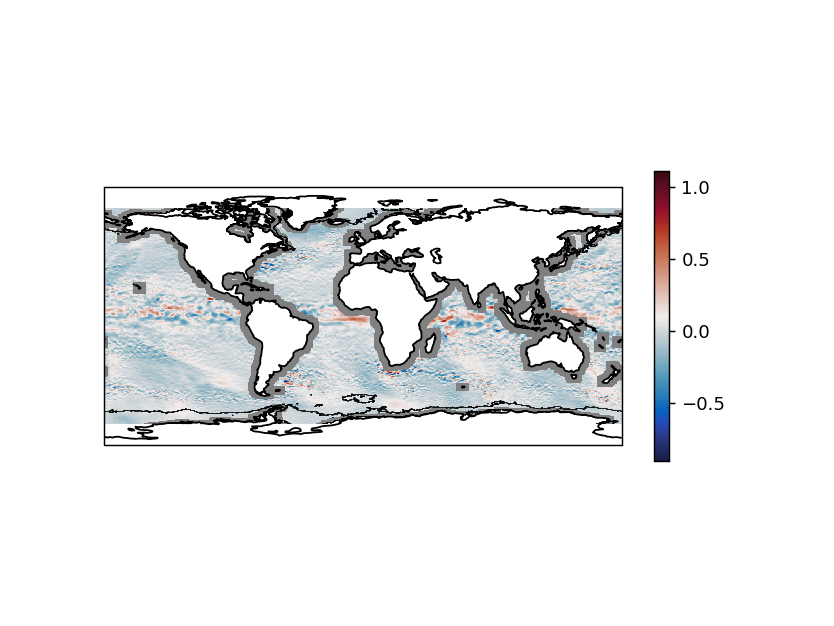

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [24]:
plotter.plot(v.isel(time=0)['usurf'], lon=0., cmap=cmap_balance)

In [13]:
monthly_grouped.groups

{1: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  365,
  366,
  367,
  368,
  369,
  370,
  371,
  372,
  373,
  374,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395],
 2: [31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  396,
  397,
  398,
  399,
  400,
  401,
  402,
  403,
  404,
  405,
  406,
  407,
  408,
  409,
  410,
  411,
  412,
  413,
  414,
  415,
  416,
  417,
  418,
  419,
  420,
  421,
  422,
  423],
 3: [59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  424,
  425,
  426,
  427,
  428,
  429,
  43

In [11]:
with ProgressBar():
    rr = monthly_grouped.compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'DatasetGroupBy' object has no attribute 'compute'

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


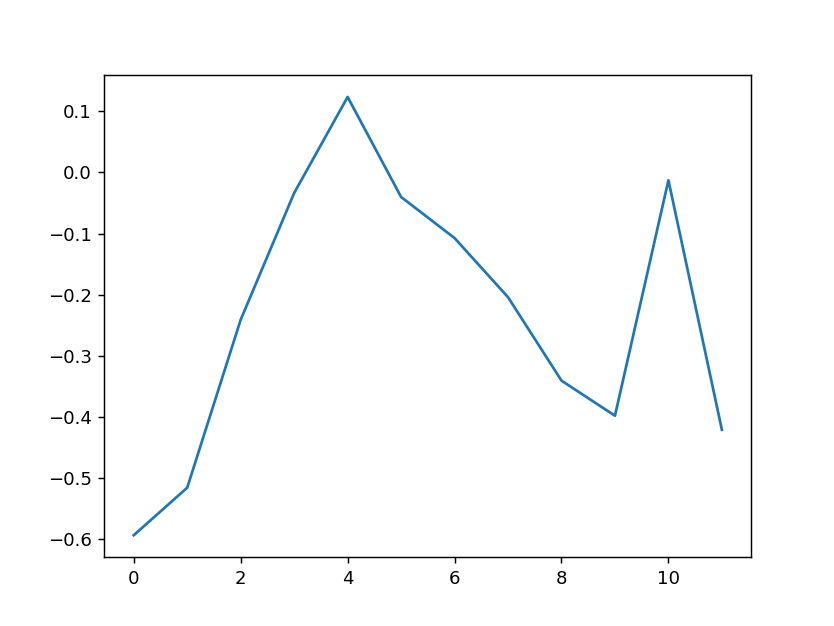

In [23]:
plt.figure()
plt.plot(monthly_means['usurf'].sel(longitude=-161, latitude=0, method='nearest'))

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


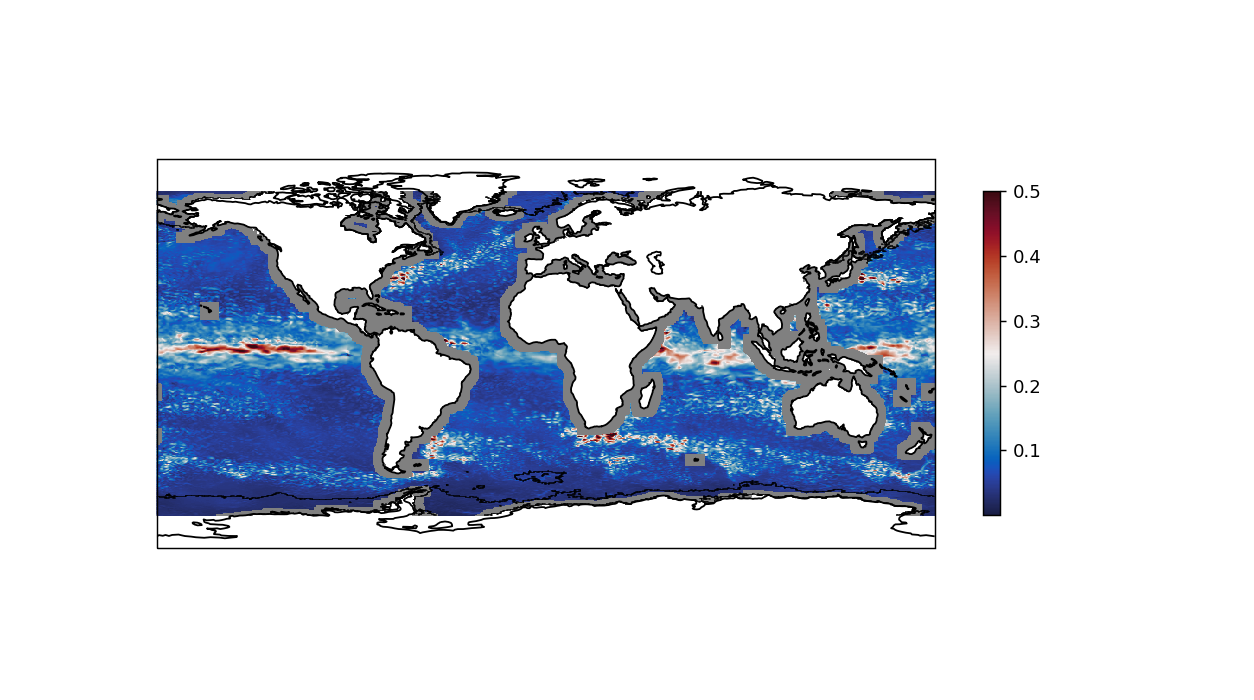

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [29]:
plotter.plot(monthly_stds['usurf'].sel(month=10), lon=0., cmap=cmap_balance, vmax=0.5)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


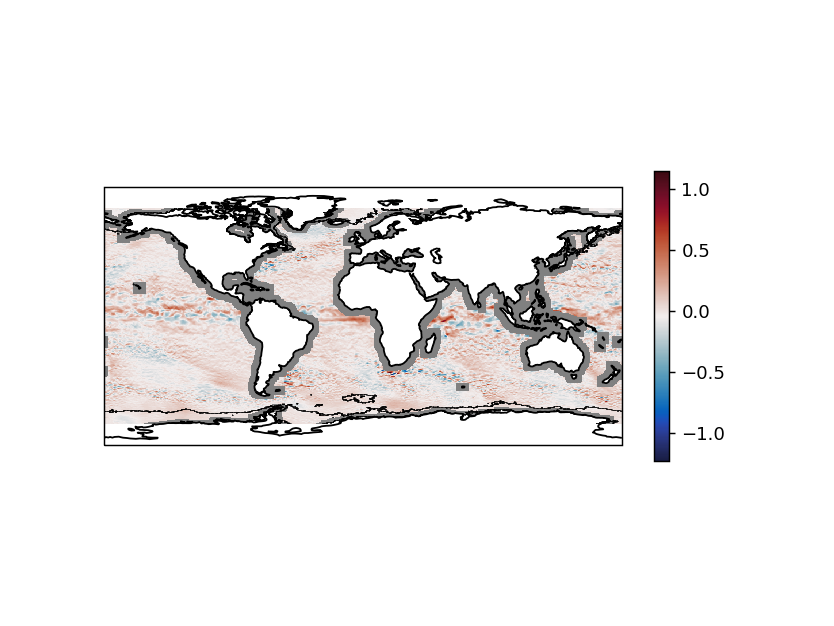

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [25]:
plotter.plot(data['usurf'].isel(time=0) - monthly_means['usurf'].sel(month=1), lon=0, cmap=cmap_balance)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


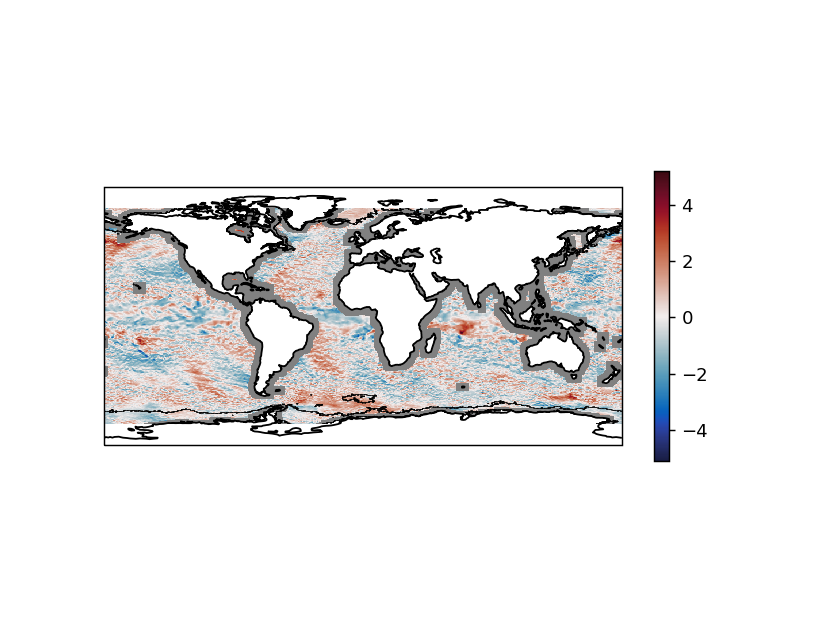

Using cached version!
Using cached version!


<GeoAxesSubplot:>

In [27]:
plotter.plot(data_n['usurf'].isel(time=100), lon=0., cmap=cmap_balance)

In [17]:
var = t.apply(data)

TypeError: GroupBy objects only support binary ops when the other argument is a Dataset or DataArray